# PLANT DISEASE DETECTION USING CNN

In [1]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
import pickle

### READING DATASET

In [2]:
path = 'C:/Users/sri suvetha/Desktop/DATA/train'
testRatio = 0.2
valRatio = 0.2
imageDimensions= (128,128,3)
batchSizeVal= 50
epochsVal = 3

In [26]:
count = 0
images = []     # LIST CONTAINING ALL THE IMAGES
classNo = []    # LIST CONTAINING ALL THE CORRESPONDING CLASS ID OF IMAGES
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses = len(myList)
print(myList)
print("Importing Classes .......")
for x in range (0,noOfClasses):
    myPicList = os.listdir(path+"/"+str(x))
    
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(x)+"/"+y)
        curImg = cv2.resize(curImg,(128,128))
        images.append(curImg)
        classNo.append(x)
    print(x,end= " ")
print(" ")
print("Total Images in Images List = ",len(images))
print("Total IDS in classNo List= ",len(classNo))

Total Classes Detected: 9
['0', '1', '2', '3', '4', '5', '6', '7', '8']
Importing Classes .......
0 1 2 3 4 5 6 7 8  
Total Images in Images List =  9000
Total IDS in classNo List=  9000


### SPILITING TRAINING AND TESTING DATAS

In [28]:
images = np.array(images)
classNo = np.array(classNo)
print(images.shape)

# SPLITTING THE DATA
X_train,X_test,y_train,y_test = train_test_split(images,classNo,test_size=testRatio)
X_train,X_validation,y_train,y_validation = train_test_split(X_train,y_train,test_size=valRatio)
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(9000, 128, 128, 3)
(5760, 128, 128, 3)
(1800, 128, 128, 3)
(1440, 128, 128, 3)


[665, 638, 658, 641, 645, 640, 617, 611, 645]


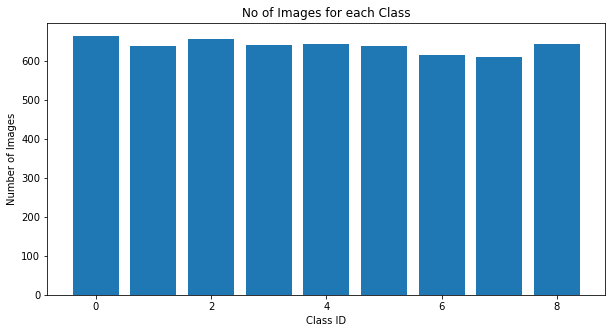

In [29]:
numOfSamples= []
for x in range(0,noOfClasses):
    #print(len(np.where(y_train==x)[0]))
    numOfSamples.append(len(np.where(y_train==x)[0]))
print(numOfSamples)

plt.figure(figsize=(10,5))
plt.bar(range(0,noOfClasses),numOfSamples)
plt.title("No of Images for each Class")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.show()

### PREPROCESSING THE DATA

In [30]:
def preProcessing(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img

X_train= np.array(list(map(preProcessing,X_train)))
X_test= np.array(list(map(preProcessing,X_test)))
X_validation= np.array(list(map(preProcessing,X_validation)))

In [31]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
X_validation = X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)

In [32]:
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
dataGen.fit(X_train)

In [33]:
y_train = to_categorical(y_train,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)

### TRAINING THE DATA

In [34]:
def myModel():
    noOfFilters = 60
    sizeOfFilter1 = (5,5)
    sizeOfFilter2 = (3, 3)
    sizeOfPool = (2,2)
    noOfNodes= 500

    model = Sequential()
    model.add((Conv2D(noOfFilters,sizeOfFilter1,input_shape=(imageDimensions[0],
                      imageDimensions[1],1),activation='relu')))
    model.add((Conv2D(noOfFilters, sizeOfFilter1, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(noOfNodes,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))

    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

model = myModel()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 124, 124, 60)      1560      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 120, 120, 60)      90060     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 60)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 58, 58, 30)        16230     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 30)        8130      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 30)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 30)       

In [35]:
history = model.fit_generator(dataGen.flow(X_train,y_train,
                                 batch_size=batchSizeVal),
                                 epochs=epochsVal,
                                 validation_data=(X_validation,y_validation),
                                 shuffle=1)

Epoch 1/3
116/116 [==============================] - 16748s 144s/step - loss: 2.0891 - accuracy: 0.2089 - val_loss: 1.7132 - val_accuracy: 0.3931
Epoch 2/3
116/116 [==============================] - 809s 7s/step - loss: 1.8109 - accuracy: 0.3358 - val_loss: 1.5911 - val_accuracy: 0.4681
Epoch 3/3
116/116 [==============================] - 876s 8s/step - loss: 1.6658 - accuracy: 0.3990 - val_loss: 1.4276 - val_accuracy: 0.5028


In [36]:
model.metrics_names

['loss', 'accuracy']

In [37]:
model.evaluate(X_test,y_test)

57/57 [==============================] - 36s 637ms/step - loss: 1.4728 - accuracy: 0.5094


[1.472795009613037, 0.5094444155693054]

In [38]:
model.save('newdlmodel.h5')
print("Saving the model as mnist.h5")

Saving the model as mnist.h5


### TESTING THE DATA

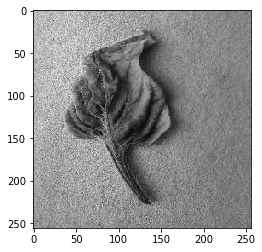

In [39]:
img = cv2.imread('C:/Users/sri suvetha/Desktop/t.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap ='gray')

In [40]:
img = cv2.equalizeHist(img)
img = img/255

In [41]:
img = cv2.resize(img,(128,128))

img = img.reshape(1,128,128,1)

In [42]:
classIndex = int(model.predict_classes(img))

predictions = model.predict(img)

probVal= np.amax(predictions)
print(classIndex,probVal)

7 0.5537255


In [43]:
if classIndex == 0:
    print('The plant disease is identifies as BACTERIAL SPOT')
elif classIndex == 1:
    print('The plant disease is identifies as EARLY BLIGHT')
elif classIndex == 2:
    print('The plant disease is identifies as LATE BLIGHT')
elif classIndex == 3:
    print('The plant disease is identifies as LEAF MOLD')
elif classIndex == 4:
    print('The plant disease is identifies as SEPTORIA LEAF SPOT')
elif classIndex == 5:
    print('The plant disease is identifies as SPIDER MITES')
elif classIndex ==6:
    print('The plant disease is identifies as TARGET SPOT')
elif classIndex == 7:
    print('The plant disease is identifies as MOSAIC VIRUS')
else:
    print('The plant disease is identifies as YELLOW LEAF CURL VIRUS')

The plant disease is identifies as MOSAIC VIRUS
